# Setup

Importações de bibliotecas necessárias para análise, extração e carregamento da base de dados

In [70]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import re
from sklearn.preprocessing import scale, PowerTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
import plotly.express as px
from sklearn.mixture import GaussianMixture

In [4]:
# Carregando a base de dados no vscode diretamente do kaggle
od.download_kaggle_dataset('https://www.kaggle.com/datasets/carrie1/ecommerce-data', data_dir=r'C:\Users\ncavalli\OneDrive - INTERCONEXION ELECTRICA S.A. E.S.P\Documentos\desafio_7_DNC/base_de_dados')

Skipping, found downloaded files in "C:\Users\ncavalli\OneDrive - INTERCONEXION ELECTRICA S.A. E.S.P\Documentos\desafio_7_DNC/base_de_dados\ecommerce-data" (use force=True to force download)


In [5]:
# Carregando a base de dados no notebook
df = pd.read_csv('../base_de_dados/ecommerce-data/data.csv', encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Análise Exploratória dos Dados

Análise descritiva dos dados, verificando padrões, relação e distribuição entre variáveis.

In [6]:
# Verificando o formato do dataset
df.shape

(541909, 8)

O dataset possui 541909 linhas e 8 colunas

In [7]:
# Verificando os tipos dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Examinando os tipos de dados, verifica-se que serão necessárias alterações nos tipos de dados das features InvoiceDate e CustomerID. Essas colunas serão tratadas posteriormente.

In [8]:
#Aplicando estatística descritiva para análise das colunas numéricas.
df[['Quantity', 'UnitPrice']].describe(percentiles=[.01, .1, .25, .5, .75, .9, .99])

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
1%,-2.000000,0.190000
10%,1.000000,0.630000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
90%,24.000000,7.950000


Verificando a descrição dos dados, notamos que a média tem valor maior que a mediana dos dados, isso pode indicar que não temos uma distribuição uniforme. Outro ponto são valores negativos tanto na quantidade como no preço único dos produtos e será tratado posteriormente.

<Axes: ylabel='Quantity'>

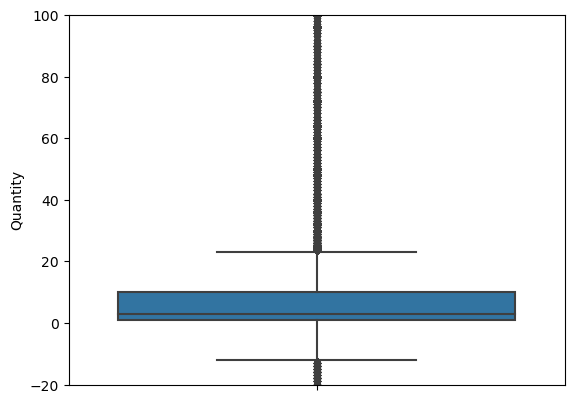

In [9]:
#Plotando o gráfico boxplot para a coluna Quantity a fim de identificar outliers
plt.ylim(-20, 100)
sns.boxplot(y=df['Quantity'])

<Axes: ylabel='UnitPrice'>

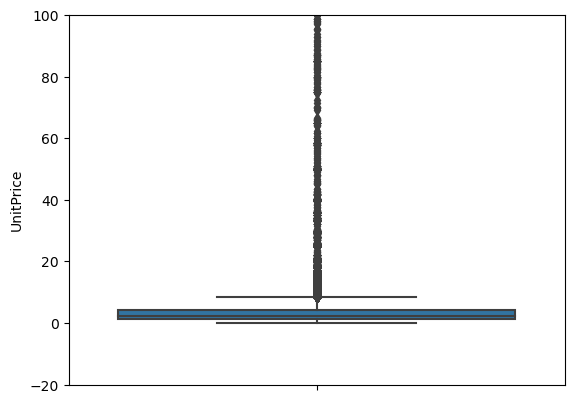

In [10]:
#Plotando o gráfico boxplot para a coluna UnitPrice a fim de identificar outliers
plt.ylim(-20, 100)
sns.boxplot(y=df['UnitPrice'])

Pelo gráfico de boxplot podemos notar uma variedade de outliers no dataset, tanto para a coluna, Quantity como para a coluna UnitPrice. Serão tratados posteriormente

In [11]:
#Verificando a distribuição dos dados para as colunas categóricas
def distribuicao_variavel(df:pd.DataFrame, col:str):
    df_distribuicao = df[col].value_counts(normalize=True).to_frame('Porcentagem').reset_index()
    plt.figure(figsize=(20, 20))
    plt.xticks(rotation=60)
    ax = sns.barplot(data=df_distribuicao, x=col, y='Porcentagem', orient='v', color='blue')

    return ax

<Axes: xlabel='Country', ylabel='Porcentagem'>

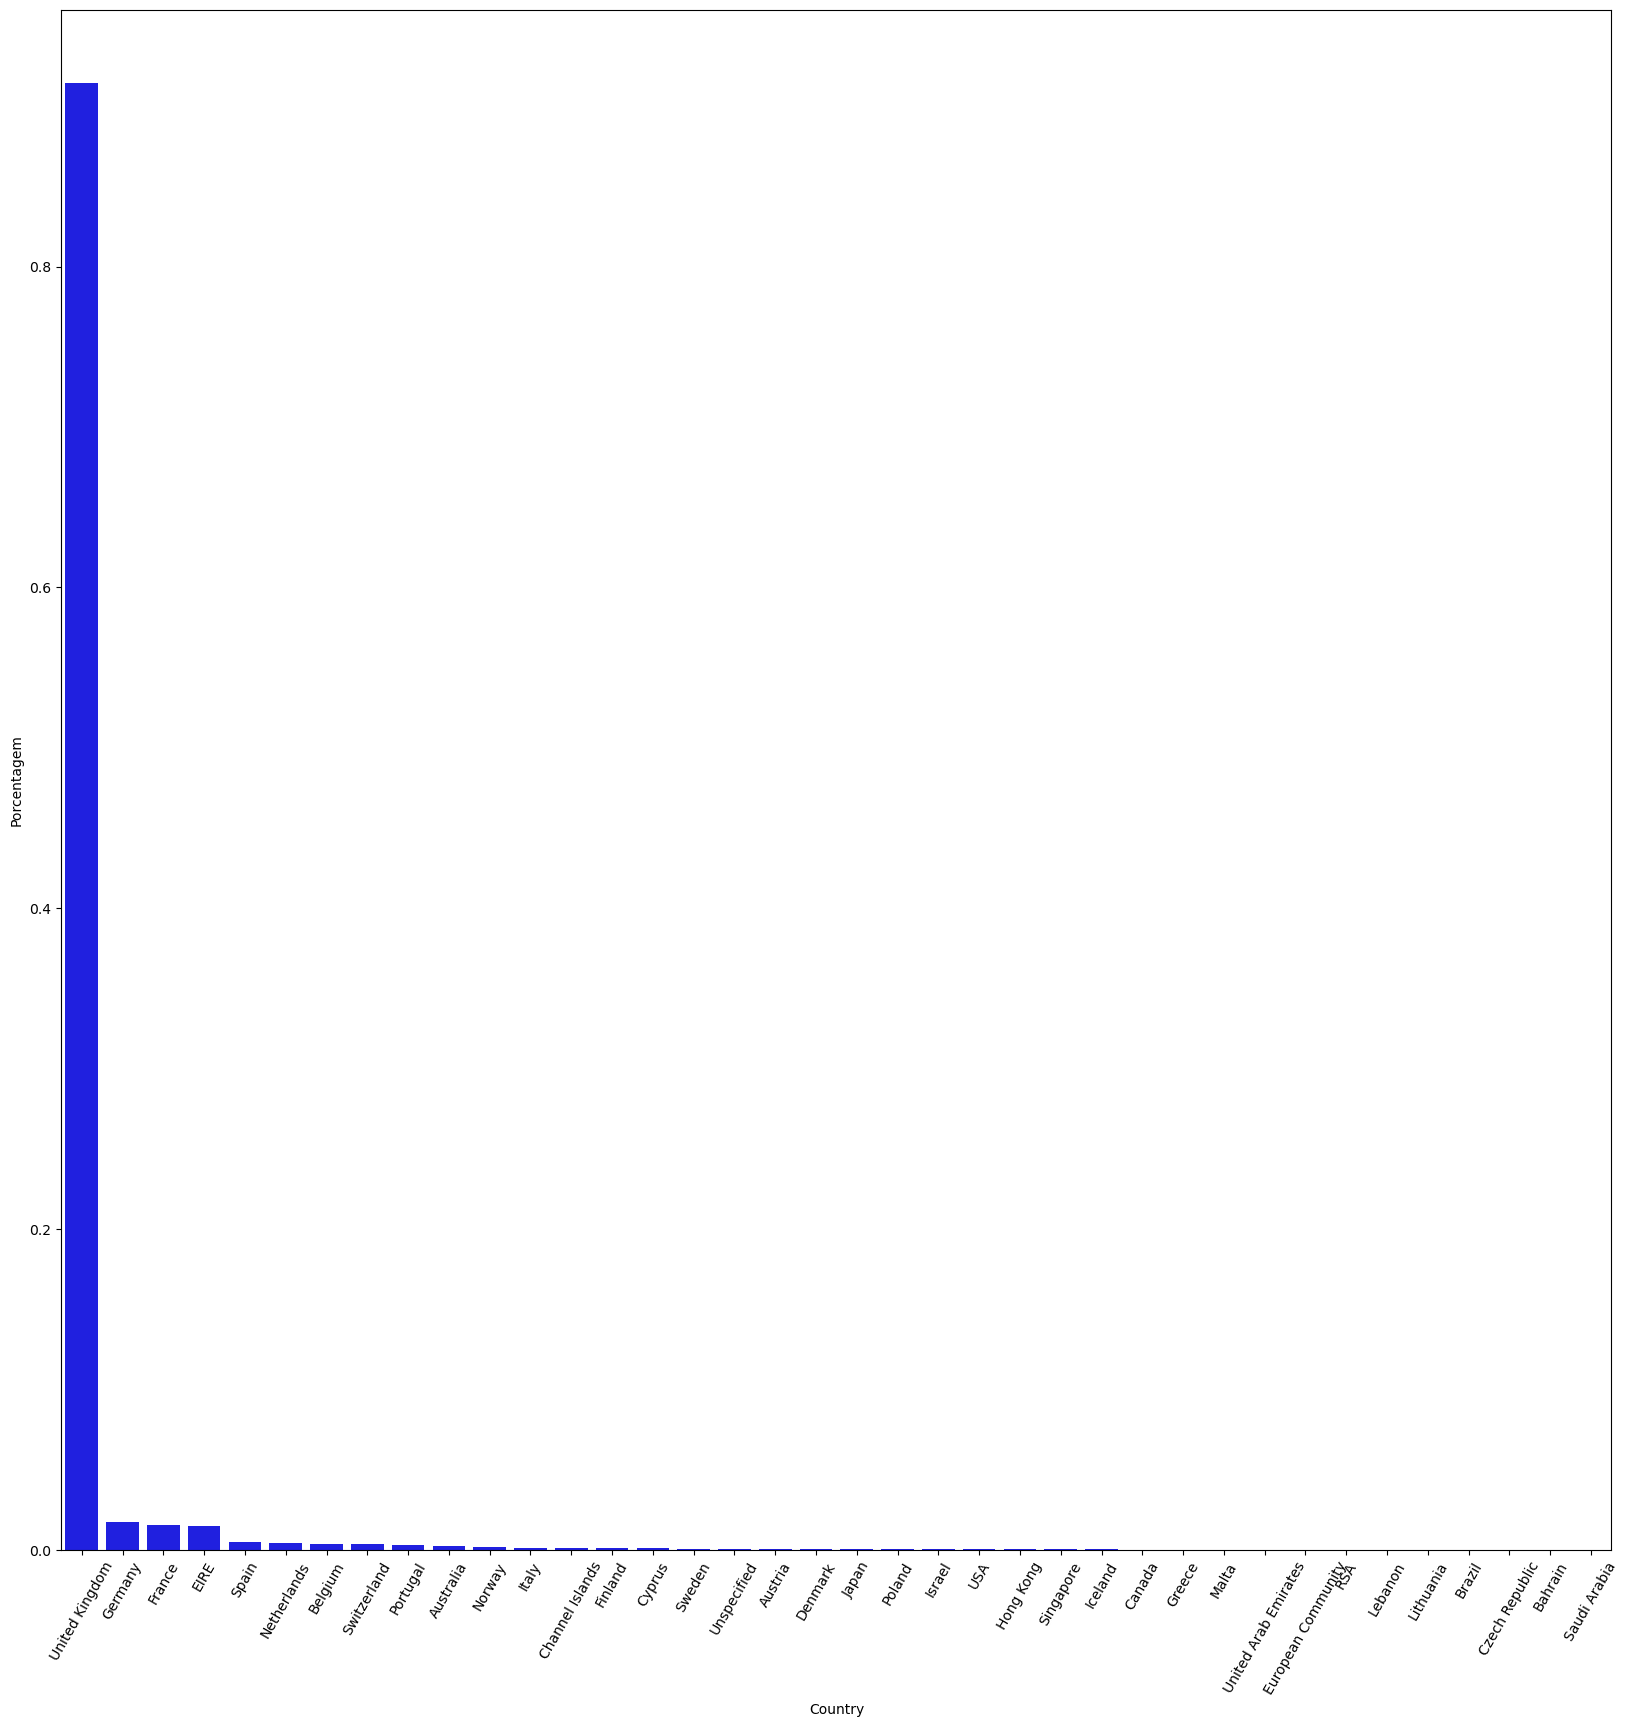

In [12]:
#Aplicando a função criada acima para as colunas do dataset
distribuicao_variavel(df, 'Country')

In [13]:
#Verificando a distribuição dos dados para as colunas categóricas
df['Description'].value_counts(normalize=True).to_frame('porcentagem').reset_index()

,Description,porcentagem
0,WHITE HANGING HEART T-LIGHT HOLDER,0.004383
1,REGENCY CAKESTAND 3 TIER,0.004071
2,JUMBO BAG RED RETROSPOT,0.003995
3,PARTY BUNTING,0.003195
4,LUNCH BAG RED RETROSPOT,0.003031
...,...,...
4218,Missing,0.000002
4219,historic computer difference?....se,0.000002
4220,DUSTY PINK CHRISTMAS TREE 30CM,0.000002
4221,WRAP BLUE RUSSIAN FOLKART,0.000002


91 % das transações são de clientes do Reino Unido e não temos um produto predominante nas transações dos clientes

Vamos transformar a coluna `InvoiceDate` para datetime já na fase de exploração dos dados para conseguir realizar análises temporais com os dados.

In [14]:
#Transformando a coluna invoicedate em tipo datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

Aqui criaremos um gráfico de linha para identificar sazonalidades e o comportamento das transações no período dos dados descritos.

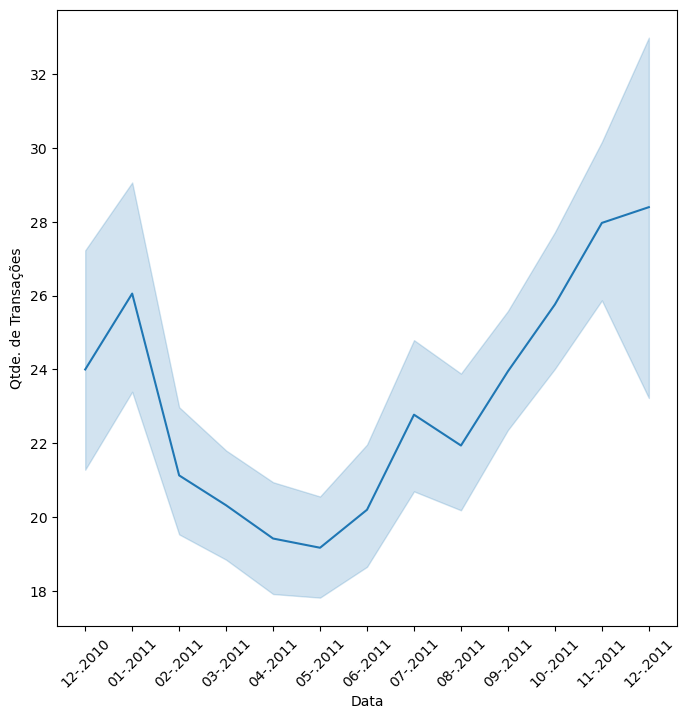

In [15]:
# Agrupando o número de transações realizadas pela data
agrupado = df.groupby('InvoiceDate')['InvoiceNo'].count()

# Transformando em um dataframe e criando uma coluna de mês-ano
df_agrupado = pd.DataFrame(agrupado).reset_index()
df_agrupado['mes_ano'] = df_agrupado['InvoiceDate'].dt.strftime('%m-.%Y')

#Aplicando o lineplot da biblioteca seaborn para plotar o gráfico
plt.figure(figsize=(8, 8))
plt.xticks(rotation=45)
plt.xlabel('Data')
plt.ylabel('Qtde. de Transações')
sns.lineplot(data=df_agrupado, x='mes_ano', y='InvoiceNo');


Pontos Importantes:
- Tendência de crescimento acentuado nas vendas a partir de maio de 2011
- Como foi um período de tempo curto, não foi possível identificar sazonalidade nos dados. Com mais dados poderíamos identificar um padrão mais claro.
- Comparando os últimos meses do ano de 2010 com 2011, nota-se que temos um significativo nas vendas em 2011 em relação 2010.

In [16]:
#Verificando se temos valores nulos
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

As colunas de Description e CustomerID apresentam valores nulos que serão tratados na próxima etapa.

In [17]:
#Verificando se temos valores duplicados
df.duplicated().sum()

5268

Nota-se que temos quase 5268 valores duplicados que serão excluidos na próxima etapa.

In [18]:
#Verificando as linhas com duplicadas
df[df.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


# Pré-processamento dos dados

## Padronizando os nomes das colunas

In [19]:
# Padronizando os nomes das colunas para minusculo e trocando os espaços por '_' com a função abaixo

def padroniza_coluna(df:pd.DataFrame):
    for col in df.columns:

        if bool(re.search(r"\s", col))  == True:
            new_col = re.sub(r"\s", r"_", col)
            df.rename(columns={col : new_col}, inplace=True)
            df.rename(columns={new_col : new_col.lower()}, inplace=True)
        else:
            df.rename(columns={col : col.lower()}, inplace=True)

padroniza_coluna(df)
df.columns

Index(['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate',
       'unitprice', 'customerid', 'country'],
      dtype='object')

## Removendo as duplicadas

In [20]:
#Removendo as duplicatas e verificando se realmente foi excluído do dataset
df.drop_duplicates(inplace=True)
df.duplicated().any()

False

## Tratando os valores nulos

Vamos criar uma função para tratar os valores nulos separadamente das colunas `description` e `customerid`. Para a primeira iremos aplicar o valor mais recorrente para os valores faltantes, enquanto para a segunda seria necessário uma análise mais minuciosa para recuperar os ids desses clientes, portanto iremos excluir os valores faltantes.

In [21]:
#excluindo os valores nulos para as colunas selecionadas

def excluir_nulos(df:pd.DataFrame, cols:list):
    df.dropna(subset=cols,inplace=True)

excluir_nulos(df, 'customerid')
df.isnull().sum()

invoiceno      0
stockcode      0
description    0
quantity       0
invoicedate    0
unitprice      0
customerid     0
country        0
dtype: int64

## Tratando os outliers

In [22]:
#Verificando o tamanho do dataset após os tratamentos realizados acima
df.shape

(401604, 8)

In [23]:
#Aplicando estatística descritiva para análise das colunas numéricas.
df[['quantity', 'unitprice']].describe(percentiles=[.01, .1, .25, .5, .75, .9, .99])

,quantity,unitprice
count,401604.000000,401604.000000
mean,12.183273,3.474064
std,250.283037,69.764035
min,-80995.000000,0.000000
1%,-2.000000,0.210000
10%,1.000000,0.550000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
90%,24.000000,6.750000


Os valores negativos para a coluna `unitprice` foram eliminados com as etapas anteriores, porém ainda temos valores negativos para a coluna `quantity`. Iremos eliminar as linhas com valores negativos e depois analisar novamente os dados.


In [24]:
#Eliminando os valores negativos para a coluna quantity
def removendo_valores_negativos(df:pd.DataFrame, col:str):
    df = df[df[col] > 0]
    return df
df = removendo_valores_negativos(df, 'quantity')


In [25]:
#Aplicando estatística descritiva para análise das colunas numéricas.
df[['quantity', 'unitprice']].describe(percentiles=[.01, .1, .25, .5, .75, .9, .99])

,quantity,unitprice
count,392732.000000,392732.000000
mean,13.153718,3.125596
std,181.588420,22.240725
min,1.000000,0.000000
1%,1.000000,0.210000
10%,1.000000,0.550000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
90%,24.000000,6.350000


In [26]:
# Criando função para remover os outliers
def remover_outliers(df:pd.DataFrame, columns:list):
    for col in columns: 
        q1 = df[col].quantile(.25)
        q3 = df[col].quantile(.75)
        lim_inferior = q1 - 3 * np.std(df[col])
        lim_superior = q3 + 3 * np.std(df[col])
        df = df[(df[col] >= lim_inferior) & (df[col] <= lim_superior)]

    return df

df = remover_outliers(df, ['quantity', 'unitprice'])

In [27]:
#Aplicando estatística descritiva para análise das colunas numéricas.
df[['quantity', 'unitprice']].describe(percentiles=[.01, .1, .25, .5, .75, .9, .99])

,quantity,unitprice
count,392124.000000,392124.000000
mean,11.815604,2.890614
std,26.050118,3.242686
min,1.000000,0.000000
1%,1.000000,0.210000
10%,1.000000,0.550000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
90%,24.000000,6.350000


Não podemos ter valor 0 de unit price, por isso iremos filtrar os valores maiores que 0

In [28]:
#Filtrando os valores válidos com a função criada anteriormente
df = removendo_valores_negativos(df, 'unitprice')
#Aplicando estatística descritiva para análise das colunas numéricas.
df[['quantity', 'unitprice']].describe(percentiles=[.01, .1, .25, .5, .75, .9, .99])

,quantity,unitprice
count,392085.000000,392085.000000
mean,11.813352,2.890902
std,26.042787,3.242719
min,1.000000,0.001000
1%,1.000000,0.210000
10%,1.000000,0.550000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
90%,24.000000,6.350000


## Tratando os tipos de dados das coluna citadas na primeira etapa

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392085 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    392085 non-null  object        
 1   stockcode    392085 non-null  object        
 2   description  392085 non-null  object        
 3   quantity     392085 non-null  int64         
 4   invoicedate  392085 non-null  datetime64[ns]
 5   unitprice    392085 non-null  float64       
 6   customerid   392085 non-null  float64       
 7   country      392085 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 26.9+ MB


In [30]:
#Transformando a coluna customerid em string
df['customerid'] = df['customerid'].astype(int)
df['customerid'] = df['customerid'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392085 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    392085 non-null  object        
 1   stockcode    392085 non-null  object        
 2   description  392085 non-null  object        
 3   quantity     392085 non-null  int64         
 4   invoicedate  392085 non-null  datetime64[ns]
 5   unitprice    392085 non-null  float64       
 6   customerid   392085 non-null  object        
 7   country      392085 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 26.9+ MB


## Feature Engeneering

Vamos realizar a criação de três colunas para o dataset, são elas:
- valor_total (a coluna quantity x unit price)
- hora (separar da coluna data)
- mes-ano

In [31]:
#Criando a coluna valor total
df['valor_total'] = df['quantity'] * df['unitprice']
df

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,valor_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [32]:
#Criando a coluna hora
df['hora'] = df['invoicedate'].dt.hour
df

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,valor_total,hora
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,8
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,12


In [33]:
#Eliminando as horas da coluna data
df['invoicedate'] = df['invoicedate'].dt.date

In [34]:
# Transformando novamente para o tipo data
df['invoicedate'] = pd.to_datetime(df['invoicedate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392085 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    392085 non-null  object        
 1   stockcode    392085 non-null  object        
 2   description  392085 non-null  object        
 3   quantity     392085 non-null  int64         
 4   invoicedate  392085 non-null  datetime64[ns]
 5   unitprice    392085 non-null  float64       
 6   customerid   392085 non-null  object        
 7   country      392085 non-null  object        
 8   valor_total  392085 non-null  float64       
 9   hora         392085 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(5)
memory usage: 31.4+ MB


In [35]:
# Criando a coluna mês-ano
df['mes-ano'] = df['invoicedate'].dt.strftime('%m-%Y')
df

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,valor_total,hora,mes-ano
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30,8,12-2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34,8,12-2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00,8,12-2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.34,8,12-2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.34,8,12-2010
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680,France,10.20,12,12-2011
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680,France,12.60,12,12-2011
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680,France,16.60,12,12-2011
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680,France,16.60,12,12-2011


Agora que realizamos parte do pré-processamento dos dados (ainda falta o cálculo do RFM), vamos realizar mais algumas análise exploratórias a fim de identificar mais padrões relevantes.

In [36]:
df.columns

Index(['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate',
       'unitprice', 'customerid', 'country', 'valor_total', 'hora', 'mes-ano'],
      dtype='object')

### 1. Países com maiores vendas (Top10)

<Axes: xlabel='country', ylabel='Faturamento Total'>

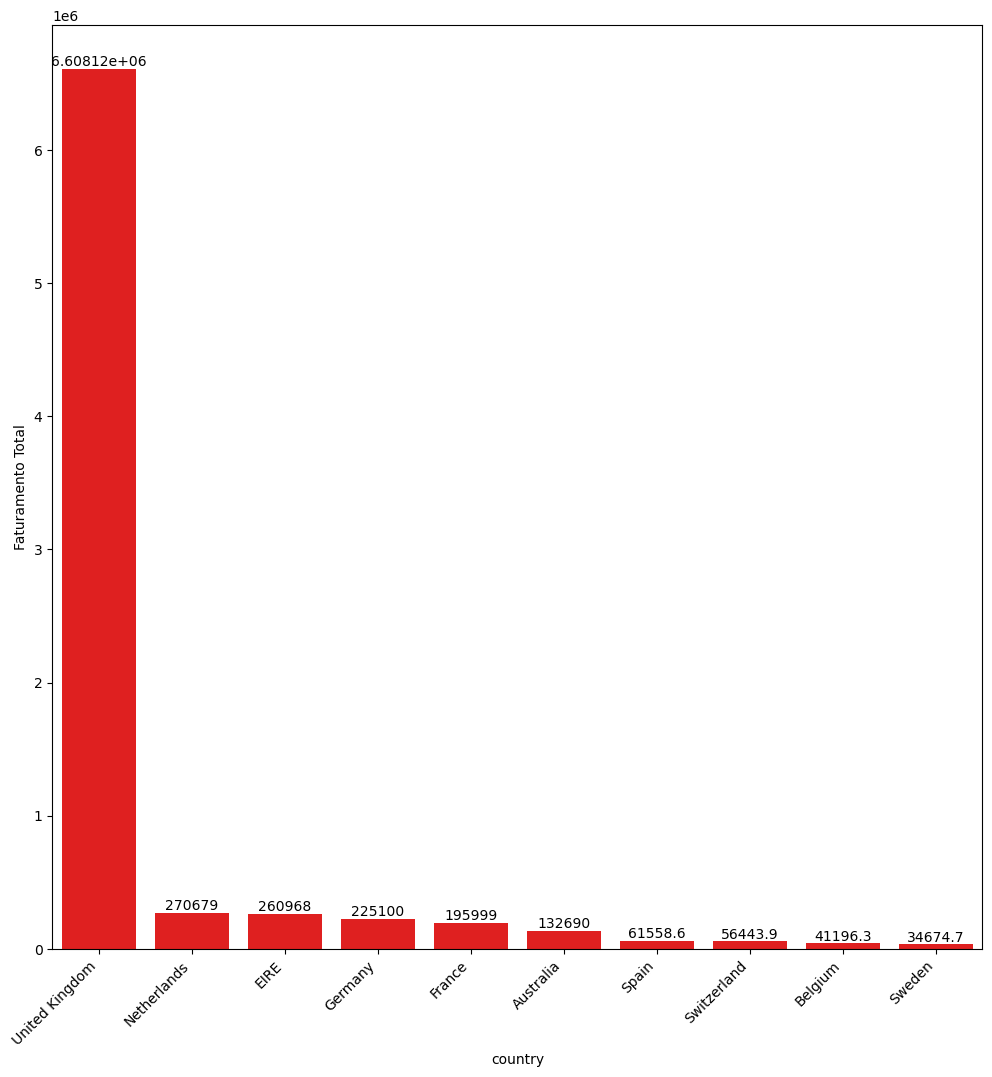

In [37]:
#Criando função para plotar gráfico com as n maiores vendas pela categoria escolhida.
def n_maiores_vendas(df:pd.DataFrame, col:str, n:int):
    top_n = pd.DataFrame(df.groupby(by=col)['valor_total'].sum().sort_values(ascending=False).head(n)).reset_index()
    plt.figure(figsize=(12, 12))
    ax = sns.barplot(data=top_n,x=col, y='valor_total',orient='v', color='red')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Faturamento Total')
    ax.bar_label(ax.containers[0])

    return ax

#Aplicando a função criada acima para a coluna country
n_maiores_vendas(df, 'country', 10)

### Top 10 Produtos mais frequentes

<Axes: xlabel='description', ylabel='Quantidade Total'>

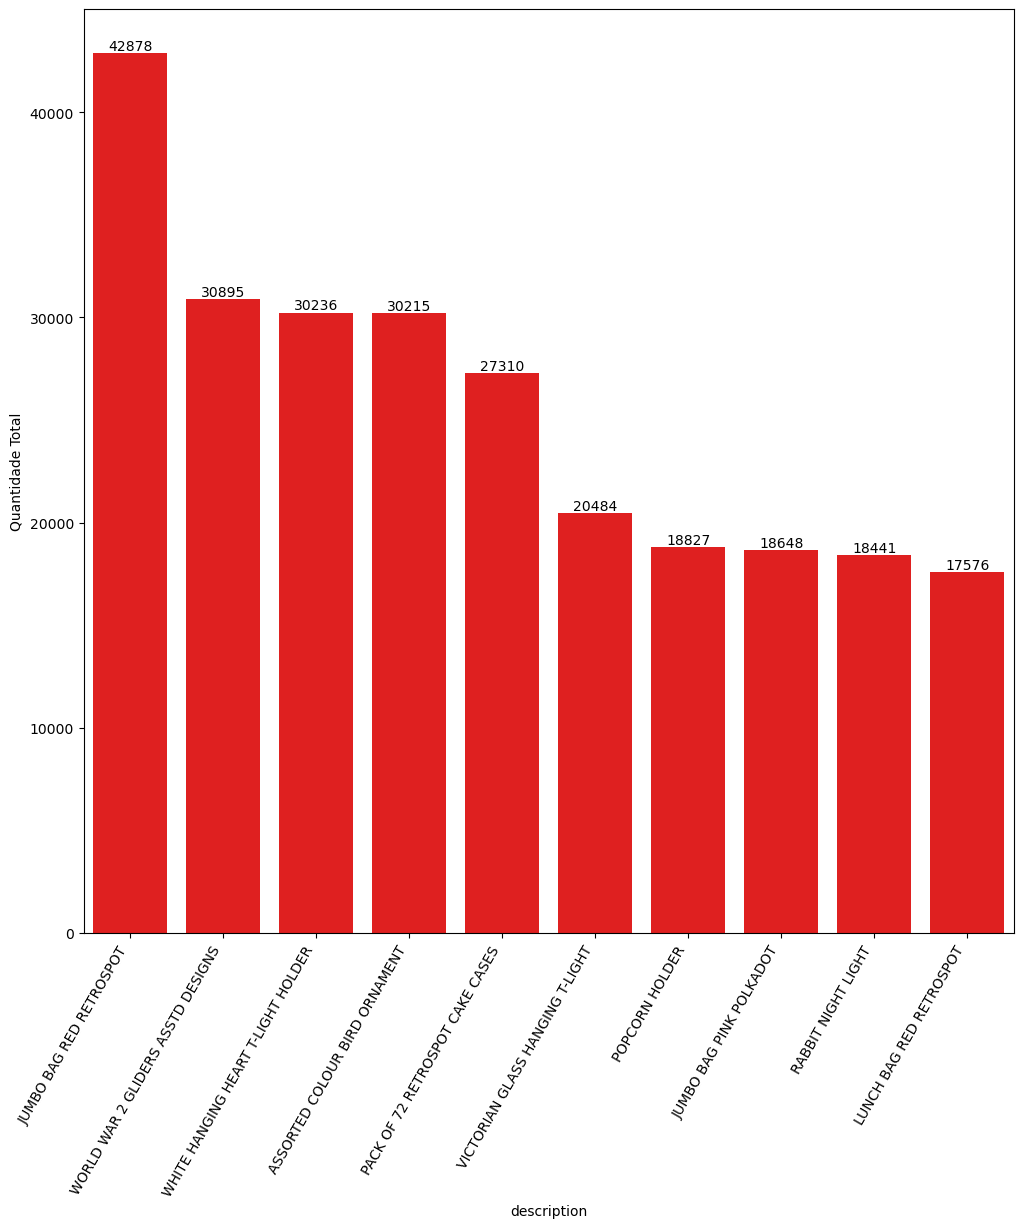

In [38]:
#Criando função para plotar gráfico com as n maiores quantidades pela categoria escolhida.
def n_maiores_qtdes(df:pd.DataFrame, col:str, n:int):
    top_n = pd.DataFrame(df.groupby(by=col)['quantity'].sum().sort_values(ascending=False).head(n)).reset_index()
    plt.figure(figsize=(12, 12))
    ax = sns.barplot(data=top_n,x=col, y='quantity',orient='v', color='red')
    plt.xticks(rotation=60, ha='right')
    plt.ylabel('Quantidade Total')
    ax.bar_label(ax.containers[0])

    return ax
# Vamos aplicar a função aplicada acima aqui também
n_maiores_qtdes(df, 'description', 10)

### Evolução do Faturamento

<Axes: xlabel='mes-ano', ylabel='valor_total'>

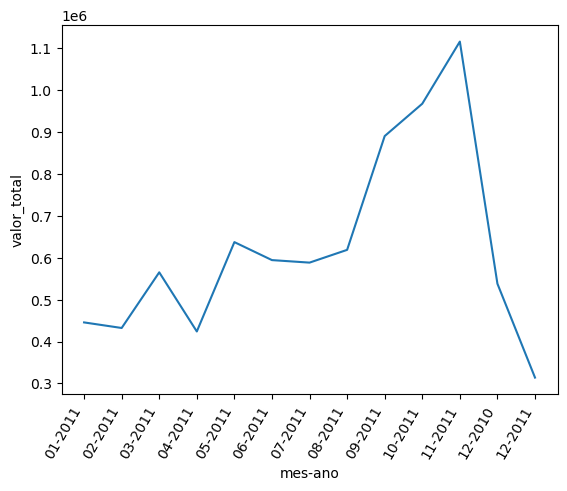

In [39]:
#Criando função para análise temporal da coluna especificada
def evolucao_mensal(df:pd.DataFrame, col:str):
    datas = pd.DataFrame(df.groupby('mes-ano')[col].sum()).reset_index().sort_values(by='mes-ano')
    ax = sns.lineplot(datas, x='mes-ano', y=col, markers=True, dashes=False)
    plt.xticks(rotation=60, ha='right')

    return ax

evolucao_mensal(df, 'valor_total')

Aqui notamos um grande pico no faturamento no mês de novembro de 2011, bem como relatamos em relação ao volume de transações mostrado anterioremente.

<Axes: xlabel='quantity', ylabel='valor_total'>

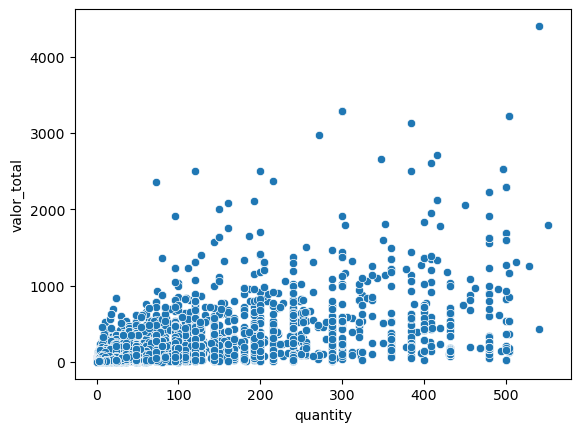

In [40]:
#Análise de dispersão da coluna valor_total em relação a quantidade
sns.scatterplot(df, x='quantity', y='valor_total')

Após algumas análise realizadas vamos criar o dataset RFM que será utilizado para o modelo de cluisterização escolhido.

### Cálculo do RFM

Para o cálculo do RFM, precisamos realizar alguns agrupamentos nos dados:
- Cliente e ID Transação
- Cliente (será o dataset utilizado para o cálculo das métricas)

In [41]:
# Agrupando os dados por cliente e id transação com o valor total e o último dia de compra.
cliente_transacao = df.groupby(by=['customerid', 'invoiceno']).agg({'valor_total' : 'sum', 'invoicedate' : 'max'}).reset_index()
cliente_transacao

,customerid,invoiceno,valor_total,invoicedate
0,12347,537626,711.79,2010-12-07
1,12347,542237,475.39,2011-01-26
2,12347,549222,636.25,2011-04-07
3,12347,556201,382.52,2011-06-09
4,12347,562032,584.91,2011-08-02
...,...,...,...,...
18372,18283,579673,220.31,2011-11-30
18373,18283,580872,208.00,2011-12-06
18374,18287,554065,765.28,2011-05-22
18375,18287,570715,1001.32,2011-10-12


In [42]:
# Agrupando por cliente com o valor total, data da última compra e quantidade compras (transações) realizadas
df_rfm = df.groupby('customerid').agg({'valor_total' : 'sum', 'invoicedate' : 'max', 'invoiceno' : 'nunique'})
df_rfm

,valor_total,invoicedate,invoiceno
customerid,,,
12347,4310.00,2011-12-07,7
12348,1797.24,2011-09-25,4
12349,1457.55,2011-11-21,1
12350,334.40,2011-02-02,1
12352,1665.74,2011-11-03,7
...,...,...,...
18280,180.60,2011-03-07,1
18281,80.82,2011-06-12,1
18282,178.05,2011-12-02,2


#### Recência

Vamos criar uma variável chamada `ultima_data` que será a última data de compra geral do nosso dataset para o cálculo da recência

In [43]:
#Criando a variável última data
ultima_data = df['invoicedate'].max()

#Calculando a recência
df_rfm['recência'] = ultima_data - df_rfm['invoicedate']
df_rfm

,valor_total,invoicedate,invoiceno,recência
customerid,,,,
12347,4310.00,2011-12-07,7,2 days
12348,1797.24,2011-09-25,4,75 days
12349,1457.55,2011-11-21,1,18 days
12350,334.40,2011-02-02,1,310 days
12352,1665.74,2011-11-03,7,36 days
...,...,...,...,...
18280,180.60,2011-03-07,1,277 days
18281,80.82,2011-06-12,1,180 days
18282,178.05,2011-12-02,2,7 days


#### Frequência

A frequência já foi calculada. Ela é a coluna `invoiceno` do dataset `df_rfm`. Por isso iremos renomeá-la para 'frequência'

In [44]:
#Renomeando a coluna invoiceno
df_rfm.rename(columns={'invoiceno' : 'frequência'}, inplace=True)
df_rfm

,valor_total,invoicedate,frequência,recência
customerid,,,,
12347,4310.00,2011-12-07,7,2 days
12348,1797.24,2011-09-25,4,75 days
12349,1457.55,2011-11-21,1,18 days
12350,334.40,2011-02-02,1,310 days
12352,1665.74,2011-11-03,7,36 days
...,...,...,...,...
18280,180.60,2011-03-07,1,277 days
18281,80.82,2011-06-12,1,180 days
18282,178.05,2011-12-02,2,7 days


#### Ticket Médio

In [45]:
# Cálculo do ticket médio
df_rfm['ticket_medio'] = df_rfm['valor_total'] / df_rfm['frequência']
df_rfm

,valor_total,invoicedate,frequência,recência,ticket_medio
customerid,,,,,
12347,4310.00,2011-12-07,7,2 days,615.714286
12348,1797.24,2011-09-25,4,75 days,449.310000
12349,1457.55,2011-11-21,1,18 days,1457.550000
12350,334.40,2011-02-02,1,310 days,334.400000
12352,1665.74,2011-11-03,7,36 days,237.962857
...,...,...,...,...,...
18280,180.60,2011-03-07,1,277 days,180.600000
18281,80.82,2011-06-12,1,180 days,80.820000
18282,178.05,2011-12-02,2,7 days,89.025000


In [46]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4319 entries, 12347 to 18287
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   valor_total   4319 non-null   float64        
 1   invoicedate   4319 non-null   datetime64[ns] 
 2   frequência    4319 non-null   int64          
 3   recência      4319 non-null   timedelta64[ns]
 4   ticket_medio  4319 non-null   float64        
dtypes: datetime64[ns](1), float64(2), int64(1), timedelta64[ns](1)
memory usage: 202.5+ KB


Note que a coluna de recência está com o tipo timedelta. Precisamos transformá-la para o tipo inteiro para conseguirmos normarlizar os dados e realizar a modelagem.

In [47]:
df_rfm['recência'] = df_rfm['recência'].dt.days
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4319 entries, 12347 to 18287
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   valor_total   4319 non-null   float64       
 1   invoicedate   4319 non-null   datetime64[ns]
 2   frequência    4319 non-null   int64         
 3   recência      4319 non-null   int64         
 4   ticket_medio  4319 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 202.5+ KB


Calculadas as métricas relevantes, iremos remover as colunas `valor_total` e `invoicedate`

In [48]:
df_rfm.drop(columns=['valor_total', 'invoicedate'], inplace=True)
df_rfm

,frequência,recência,ticket_medio
customerid,,,
12347,7,2,615.714286
12348,4,75,449.310000
12349,1,18,1457.550000
12350,1,310,334.400000
12352,7,36,237.962857
...,...,...,...
18280,1,277,180.600000
18281,1,180,80.820000
18282,2,7,89.025000


### Normalização dos dados

<Axes: >

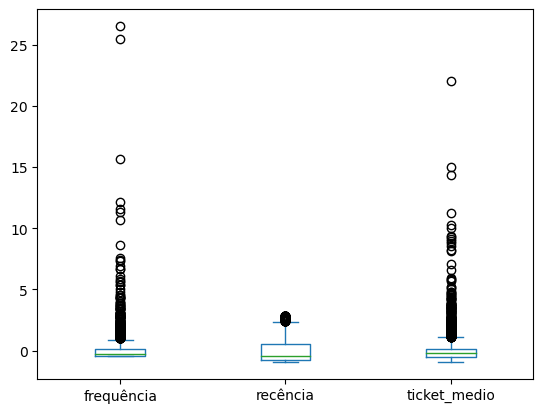

In [49]:
#Aplicando a função apply e scale para normalização e vamos plotar um gráfico boxplot para analisar se temos ainda outliers com os dados de RFM
df_rfm_scaled = df_rfm.apply(scale)
df_rfm_scaled.plot.box()

Repare que ainda temos muitos outliers mesmo realizando o pré-processamento dos dados. A fim de facilitar o nosso tratamento, iremos filtrar apenas os ticket médios menores que 20.

In [50]:
#Filtrando o ticket medio com a função query.
df_rfm_scaled.query('ticket_medio > 20')

,frequência,recência,ticket_medio
customerid,,,
12590,-0.425905,1.190459,22.048269


Verificando os pedidos de compra do consumidor que tem ricket médio > 20 para analisar se faz sentido reatirá-lo da análise

In [51]:
#Filtrando o consumidor mencionado com a função query no dataset original
df.query('customerid == "12590"')

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,valor_total,hora,mes-ano
187516,552978,85014B,RED RETROSPOT UMBRELLA,48,2011-05-12,4.95,12590,Germany,237.6,14,05-2011
187517,552978,85014A,BLACK/BLUE POLKADOT UMBRELLA,48,2011-05-12,4.95,12590,Germany,237.6,14,05-2011
187518,552978,22354,RETROSPOT PADDED SEAT CUSHION,60,2011-05-12,3.39,12590,Germany,203.4,14,05-2011
187519,552978,22558,CLOTHES PEGS RETROSPOT PACK 24,96,2011-05-12,1.25,12590,Germany,120.0,14,05-2011
187520,552978,22329,ROUND CONTAINER SET OF 5 RETROSPOT,48,2011-05-12,1.45,12590,Germany,69.6,14,05-2011
...,...,...,...,...,...,...,...,...,...,...,...
187578,552978,22934,BAKING MOULD EASTER EGG WHITE CHOC,48,2011-05-12,2.55,12590,Germany,122.4,14,05-2011
187579,552978,22932,BAKING MOULD TOFFEE CUP CHOCOLATE,96,2011-05-12,2.10,12590,Germany,201.6,14,05-2011
187580,552978,22692,DOORMAT WELCOME TO OUR HOME,10,2011-05-12,6.75,12590,Germany,67.5,14,05-2011
187581,552978,21523,DOORMAT FANCY FONT HOME SWEET HOME,10,2011-05-12,6.75,12590,Germany,67.5,14,05-2011


Iremos excluir o consumidor com ticket médio acima de 20

In [52]:
#Aplicando a função drop para exclusão
df_rfm.drop(index='12590', inplace=True)

Vamos aplicar a classe PowerTransform para normalizar os dados

In [53]:
#Instanciando a classe
scaler = PowerTransformer()

#Aplicando a instância no dataset df_rfm
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled.head()

,frequência,recência,ticket_medio
customerid,,,
12347,1.204483,-1.741133,1.104566
12348,0.664464,0.300964,0.661791
12349,-1.153866,-0.703150,2.344957
12350,-1.153866,1.573105,0.251915
12352,1.204483,-0.247722,-0.213897


<Axes: >

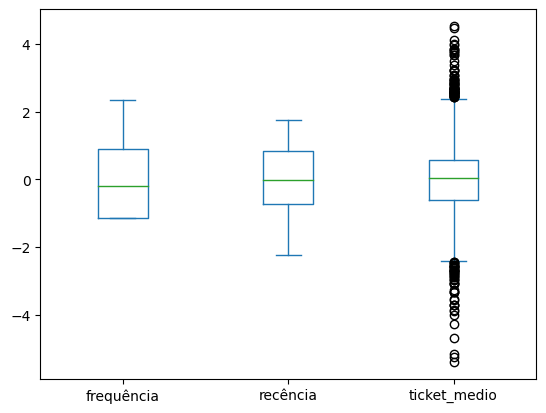

In [54]:
df_rfm_scaled.plot.box()

Note como ainda temos outliers mesmo após as normalizações dos dados. Para minimizar esse problema, iremos considerar valores até 95% dos dados.

In [55]:
#Analisando as estatísticas descritivas
df_rfm.describe()

,frequência,recência,ticket_medio
count,4318.000000,4318.000000,4318.000000
mean,4.255674,91.985873,363.086613
std,7.643973,99.956931,366.936226
min,1.000000,0.000000,2.900000
25%,1.000000,17.000000,175.277083
50%,2.000000,50.000000,286.742222
75%,5.000000,141.750000,422.805000
max,207.000000,373.000000,6207.670000


In [56]:
#Aplicando a função clip para 'cortar' os valores até 95% dos dados.
df_rfm = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm.describe()

,frequência,recência,ticket_medio
count,4318.000000,4318.000000,4318.000000
mean,3.600509,90.206114,332.552082
std,3.355401,95.502893,213.817910
min,1.000000,0.000000,2.900000
25%,1.000000,17.000000,175.277083
50%,2.000000,50.000000,286.742222
75%,5.000000,141.750000,422.805000
max,13.000000,311.000000,903.619375


In [57]:
#Padronizando os dados
df_rfm_scaled = df_rfm.apply(scale)

# Escolhendo um modelo de clusterização

Nessa etapa iremos testar alguns modelos de clusterização, para assim decidir qual o mais adequado para o nosso objetivo de negócio

### KMeans

Vamos descobrir o número de clusteres ótimos com o método de Elbow

c:\Users\ncavalli\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ncavalli\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ncavalli\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ncavalli\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ncavalli\AppData\Local\anaconda3\Li

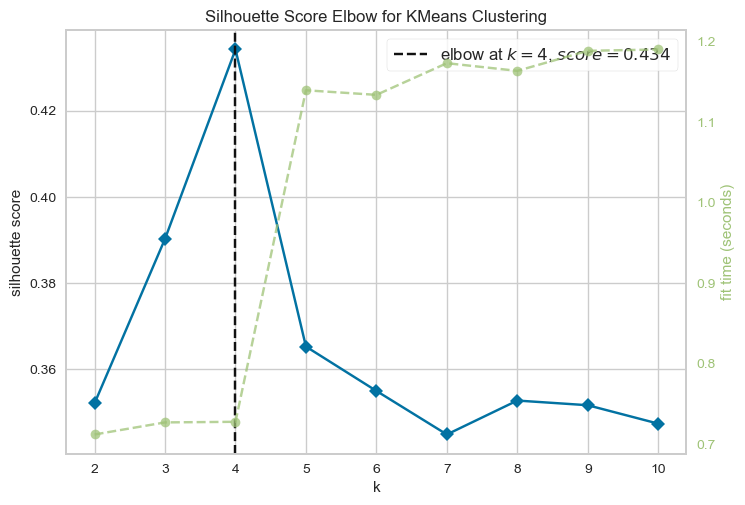

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [64]:
#Instanciando a classe KMeans
kmeans = KMeans()

#Aplicando o método de elbow
grafico_elbow = KElbowVisualizer(estimator=kmeans, k=(2, 11), metric='silhouette')
grafico_elbow.fit(df_rfm_scaled)
grafico_elbow.show()


Pelo método de elbow, concluímos que o número ideal de clusters são 4.

In [62]:
#Treinando e prevendo o dataset com o Kmeans
kmeans = KMeans(4)
kmeans_clusters = kmeans.fit_predict(df_rfm_scaled)

#Plotando os clusters em 3d com o scatter
px.scatter_3d(df_rfm_scaled, x='frequência', y='recência', z='ticket_medio', color=kmeans_clusters.astype(str), template='plotly_dark')

c:\Users\ncavalli\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Hierarchical Clustering

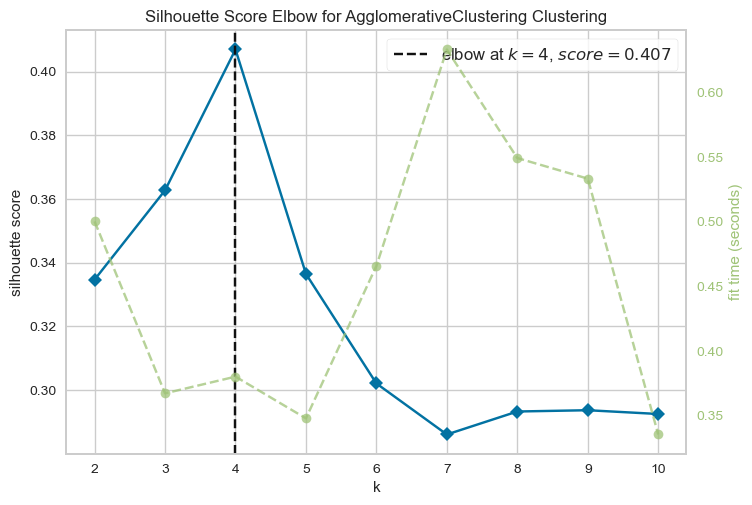

<Axes: title={'center': 'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [65]:
#Instanciando a classe KMeans
hc = AgglomerativeClustering()

#Aplicando o método de elbow
grafico_elbow = KElbowVisualizer(estimator=hc, k=(2, 11), metric='silhouette')
grafico_elbow.fit(df_rfm_scaled)
grafico_elbow.show()


In [67]:
#Treinando e prevendo o dataset com o Kmeans
hc = AgglomerativeClustering(n_clusters=4)
hc_clusters = hc.fit_predict(df_rfm_scaled)

#Plotando os clusters em 3d com o scatter
px.scatter_3d(df_rfm_scaled, x='frequência', y='recência', z='ticket_medio', color=hc_clusters.astype(str), template='plotly_dark')

### Gaussian Mixture

Para o modelo Gaussian Mixture, precisamos analisar a métrica BIC, identificando quantos componentes utilizar e qual o tipo de covariança. Para isso, vamos criar uma função que testará um determinado número de componentes dados para todos os tipos de covariância, e logo após iremos plotar o resultado obtido para verificar os melhores parâmetros.

In [74]:
#Criando a função
def gmix_params(dataset:pd.DataFrame, n_componentes:int):
    #Inicializando as variáveis necessárias
    resultados = []
    intervalo_componentes = range(1, n_componentes)
    tipos_covariancas = ['full', 'tied', 'diag', 'spherical']

    #Criando o loop para testar todas as possibilidades
    for n in intervalo_componentes:
        for ct in tipos_covariancas:
            g_mix = GaussianMixture(n_components=n, covariance_type=ct, n_init=10, warm_start=True)
            g_mix.fit(dataset)
            resultados.append(
                {'bic' : g_mix.bic(dataset),
                 'componentes' : n,
                 'tipo_covariança' : ct}
            )

    #Transformando o resultado em um dataframe
    resultados = pd.DataFrame(resultados)
    
    return resultados.sort_values('bic')

#Aplicando a função para o nosso dataset
resultados = gmix_params(df_rfm_scaled, 10)

<Axes: xlabel='componentes', ylabel='bic'>

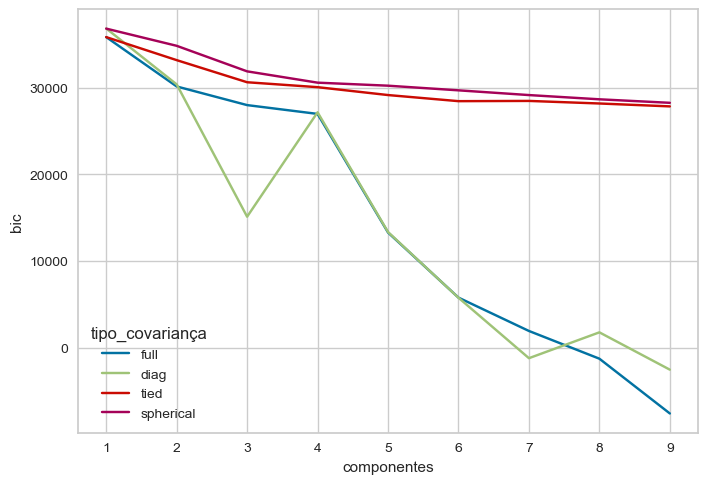

In [75]:
#Plotandoo gráfico de linha para vermos o desempenho das covarianças em relação ao número de componentes
sns.lineplot(data=resultados, x='componentes', y='bic', hue='tipo_covariança')

Analisando o gráfico de linhas para o Gaussian Mixture, vamos adotar 6 componentes como base para a clusterização e a covariança full

In [76]:
#Aplicando o modelo com os componentes definidos
g_mix = GaussianMixture(n_components=6, covariance_type='full', n_init=10)
g_mix_clusters = g_mix.fit_predict(df_rfm_scaled)

In [77]:
#Plotando os clusters em 3d com o scatter
px.scatter_3d(df_rfm_scaled, x='frequência', y='recência', z='ticket_medio', color=g_mix_clusters.astype(str), template='plotly_dark')

A fim de obtermos uma melhor representação dos clientes e analisando os 3 modelos treinados, vamos utilizar o que melhor performou para 4 clusters segundo nosso coeficiente de silhouette, que foi o KMeans. Vamos agora analisar o perfil dos nossos clientes desses 4 clusters e posteriormente definir estratégias de negócio.

# Análise dos Clusters

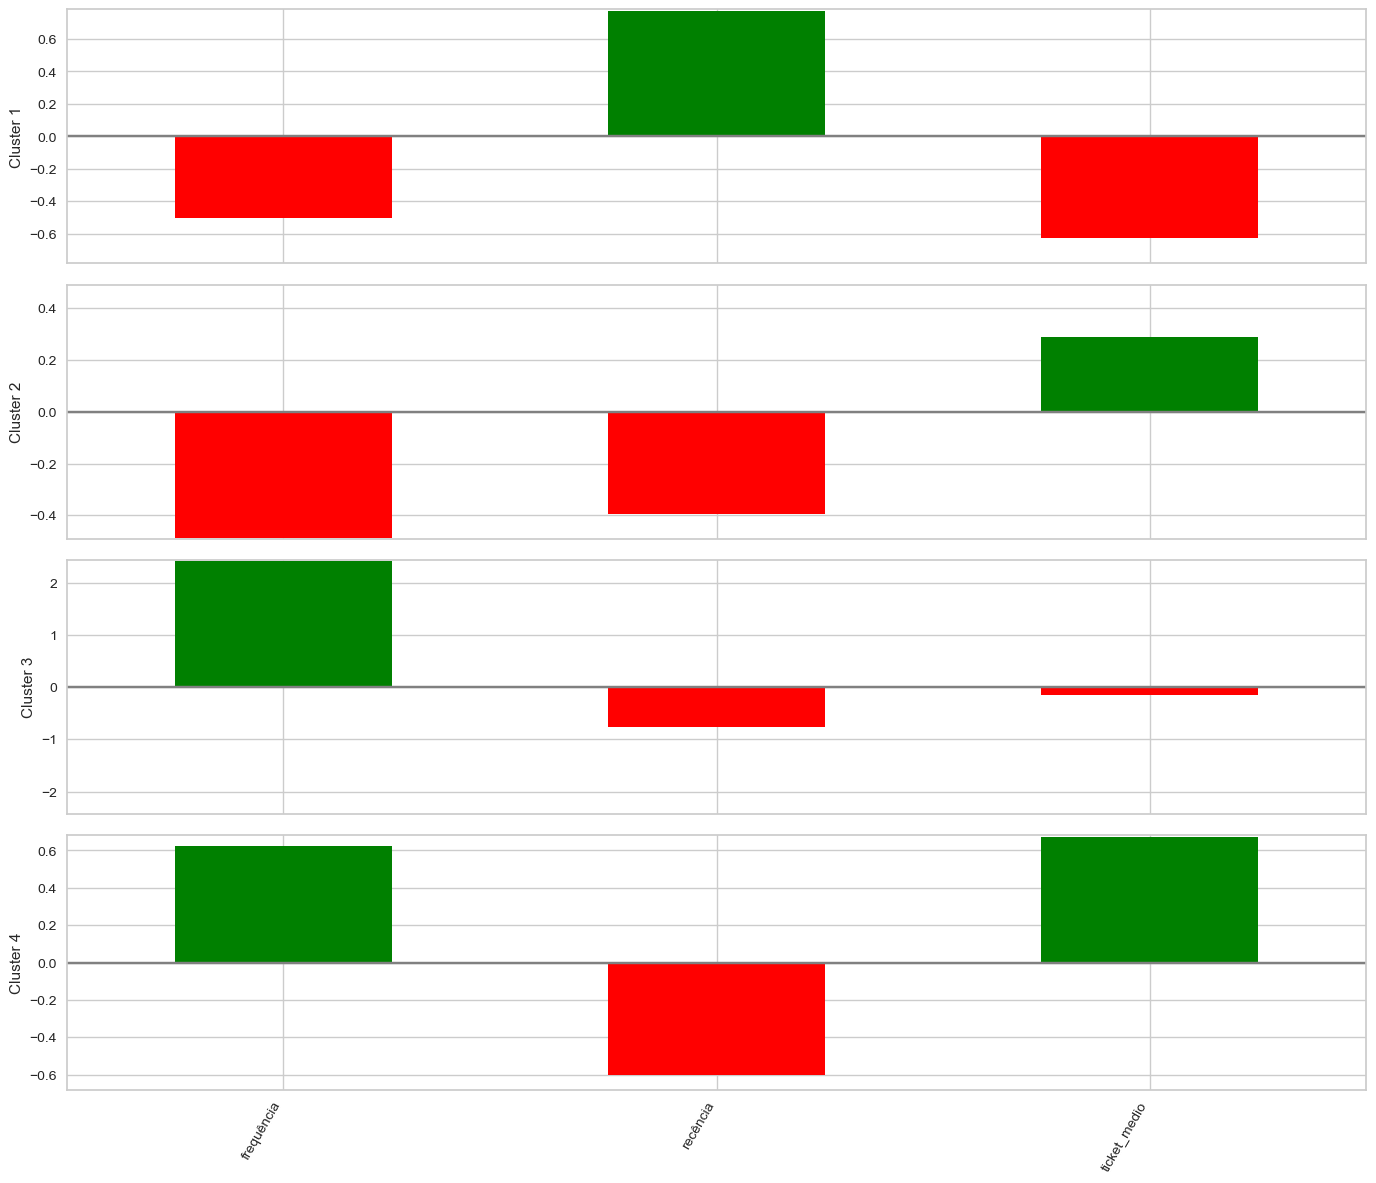

In [78]:
#Definindo um dataframe com os centroides dos clusters preditos para cada feature (RFM).
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_scaled.columns)

#Plotando um gráfico para analisar o comportamento dos clusters para cada feature
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centroides.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='yellow')
  ax.xaxis.set_ticks_position('none')

  #teste

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

# Interpretação dos Resultados

### Perfil dos Clientes

Analiasando o gráfico, podemos ver que temos realmente 4 perfis de clientes distintos. Para o `cluster 1`, potencialmente são clientes novos, pela baixa frequência de compras e ticket médio. O `cluster 2` são clientes que possuem um poder aquisitivo um pouco maior, apresentando alto valor de ticket médio, mas compram pouco e tem baixo engajamento na plataforma. O `cluster 3` são clientes que realizam compras frquentemente, porém compras de baixos valores. E o `cluster 4` são clientes assíduos da loja e realizam compras de grandes valores. 

### Justificando os resultados

Com perfis distintos como os encontrados acima, fica intuitivo e extremamente direcionado o tipo de campanha de marjeting a ser feita para perfil. Além da assertividade, essas campanhas bem direcionadas diminuirão as despesas, e aumentarão o engajamento da plataforma.

### Proposta de Negócio | Possíveis planos de ações

Com base nos resultados obtidos, uma proposta de negócio é direcionarmos uma parte do orçamento do marketing(principamente ofertas) para aqueles clientes(cluster 4) que são frequentes e tem o ticket médio alto, porém que não estão comprando muito ultimamente, fazendo com que eles voltem a comprar. Outra posposta é realizar campanhas para os novos clientes, para conseguir a fidelização do grupo e o aumento do ticket medio. Para o perfil de compras frequentes e baixo ticket medio(cluster 3) sugerimos sistemas de recomendação personalizado, para elevar o ticket médio desses compradores.